<a href="https://colab.research.google.com/github/oscaraparram/python_code_public/blob/main/JoinSaber11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Factores asociados al rendimiento académico. Un análisis desde el desarrollo territorial</h1>


<b>Brenda Eljadue Cock, Angela Ximena Muñoz Zambrano, Oscar Albeiro Parra Mateus</b>


<b>Propósito</b>: Determinar si existen desigualdades significativas en el rendimiento académico entre diferentes regiones de Colombia y si estas desigualdades están relacionadas con el nivel de desarrollo territorial
</center>

## Instalación y carga de paquetes y librerías

In [1]:
!pip install sweetviz
!pip install pycaret[full]
!pip install shap
!pip install scipy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import sweetviz as sv
import statsmodels.api as sm
import pycaret
import shap

In [3]:
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from pycaret.regression import *

## Lectura bases de datos

In [4]:
# Función de acceso al Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Lectura df saberpro
df_saberpro = pd.read_csv('/content/drive/MyDrive/1_Formacion_academica/FULL/proyecto_de_grado/analisis_estadisticos/datos/SB11_20222/SB11_20222.TXT',
                         sep='¬',
                         encoding='utf-8',
                         dtype=str)
# df_saberpro.head()

In [45]:
# Lectura df indice de madurez

# Tipo de lectura por columna. Columnas 0 a 2, string y 3 a 75, float
# columnas_a_leer = {**dict.fromkeys(range(0, 2), str), **dict.fromkeys(range(3, 75), float)}
columnas_a_leer = {**dict.fromkeys(range(0, 1), str), **dict.fromkeys(range(3, 75), float)}

df_cti = pd.read_excel('/content/drive/MyDrive/1_Formacion_academica/FULL/proyecto_de_grado/analisis_estadisticos/datos/cx_extracción_tablas.xlsx',
                       sheet_name='df_consolidado_cti',
                       dtype = columnas_a_leer
                              )

# df_cti.info()
# df_cti.head()

Limpieza y modelado de datos

In [46]:
# Vector municipios de inclusión

CodMunJoin = [
				'05001',
				'05321',
				'05313',
				'08433',
				'05368',
				'15516',
				'15763',
				'15832',
				'15185',
				'17867',
				'85010',
				'85015',
				'23815',
				'25758',
				'25473',
				'25035',
				'41020',
				'41797',
				'41551',
				'41872',
				'47001',
				'50226',
				'50124',
				'50110',
				'50711',
				'54001',
				'54518',
				'66383',
				'68001',
				'68679',
				'68235',
				'70215',
				'73001',
				'73200',
				'73030',
				'76001',
				'15839',
        '05856'
]

In [77]:
# Factores de inclusión y exclusión

UndAnalisis = df_saberpro[
    (df_saberpro['ESTU_NACIONALIDAD'] == 'COLOMBIA') &
    (df_saberpro['ESTU_PAIS_RESIDE'] == 'COLOMBIA') &
    (df_saberpro['COLE_BILINGUE'] == 'N') &
    (df_saberpro['ESTU_PRIVADO_LIBERTAD'] == 'N') &
    (df_saberpro['COLE_COD_MCPIO_UBICACION'] == df_saberpro['ESTU_COD_RESIDE_MCPIO']) &
    (df_saberpro['ESTU_COD_RESIDE_MCPIO'].isin(CodMunJoin))
]

# Eliminar los registros duplicados en función de la columna 'ww'
UndAnalisis = UndAnalisis.drop_duplicates(subset=['ESTU_CONSECUTIVO'])


# UndAnalisis.head(5)
#UndAnalisis_.columns

In [48]:
# Población de análisis

TotalRegistros = len(UndAnalisis)
TotalRegistros # Total registros 532792; aplicando factores de inclusión 66837

66837

In [49]:
# #Listar las columnas

# nombres_columnas = df_saberpro.columns
# nombres_columnas_lista = nombres_columnas.to_list()

# for columna in nombres_columnas_lista:
#    print(columna)

In [78]:
# Vector para seleccionar las variables de interes. Las comentadas son las descartadas.
VarDeInteresSaberPro = [
				# 'ESTU_TIPODOCUMENTO',
				# 'ESTU_NACIONALIDAD',
				'ESTU_GENERO',
				# 'ESTU_FECHANACIMIENTO',
				# 'PERIODO',
				# 'ESTU_CONSECUTIVO',
				# 'ESTU_ESTUDIANTE',
				# 'ESTU_PAIS_RESIDE',
				'ESTU_TIENEETNIA',
				# 'ESTU_DEPTO_RESIDE',
				# 'ESTU_COD_RESIDE_DEPTO',
				'ESTU_MCPIO_RESIDE',
				'ESTU_COD_RESIDE_MCPIO',
				'FAMI_EDUCACIONPADRE',
				'FAMI_EDUCACIONMADRE',
				'FAMI_ESTRATOVIVIENDA',
				'FAMI_PERSONASHOGAR',
				'FAMI_CUARTOSHOGAR',
				'FAMI_TIENEINTERNET',
				'FAMI_TIENECOMPUTADOR',
				'FAMI_TIENELAVADORA',
				'FAMI_TIENEHORNOMICROOGAS',
				'FAMI_TIENESERVICIOTV',
				'FAMI_TIENEAUTOMOVIL',
				'FAMI_TIENEMOTOCICLETA',
				'FAMI_TIENECONSOLAVIDEOJUEGOS',
				'FAMI_NUMLIBROS',
				'ESTU_DEDICACIONLECTURADIARIA',
				'ESTU_DEDICACIONINTERNET',
				'ESTU_HORASSEMANATRABAJA',
				'ESTU_TIPOREMUNERACION',
				'FAMI_COMELECHEDERIVADOS',
				'FAMI_COMECARNEPESCADOHUEVO',
				'FAMI_COMECEREALFRUTOSLEGUMBRE',
				'FAMI_TRABAJOLABORPADRE',
				'FAMI_TRABAJOLABORMADRE',
				'FAMI_SITUACIONECONOMICA',
				# 'COLE_COD_DANE_ESTABLECIMIENTO',
				# 'COLE_CODIGO_ICFES',
				# 'COLE_NOMBRE_ESTABLECIMIENTO',
				'COLE_JORNADA',
				'COLE_GENERO',
				'COLE_NATURALEZA',
				'COLE_CALENDARIO',
				# 'COLE_BILINGUE',
				'COLE_CARACTER',
				# 'COLE_COD_DANE_SEDE',
				# 'COLE_NOMBRE_SEDE',
				# 'COLE_SEDE_PRINCIPAL',
				# 'COLE_AREA_UBICACION',
				# 'COLE_COD_MCPIO_UBICACION',
				# 'COLE_MCPIO_UBICACION',
				# 'COLE_COD_DEPTO_UBICACION',
				# 'COLE_DEPTO_UBICACION',
				# 'ESTU_PRIVADO_LIBERTAD',
				# 'ESTU_COD_MCPIO_PRESENTACION',
				# 'ESTU_MCPIO_PRESENTACION',
				# 'ESTU_DEPTO_PRESENTACION',
				# 'ESTU_COD_DEPTO_PRESENTACION',
				'PUNT_MATEMATICAS',
				'DESEMP_MATEMATICAS',
				# 'PERCENTIL_MATEMATICAS',
				'PUNT_INGLES',
				# 'PERCENTIL_INGLES',
				'DESEMP_INGLES',
				'PUNT_C_NATURALES',
				'DESEMP_C_NATURALES',
				# 'PERCENTIL_C_NATURALES',
				'PUNT_LECTURA_CRITICA',
				'DESEMP_LECTURA_CRITICA',
				# 'PERCENTIL_LECTURA_CRITICA',
				'PUNT_SOCIALES_CIUDADANAS',
				'DESEMP_SOCIALES_CIUDADANAS',
				# 'PERCENTIL_SOCIALES_CIUDADANAS',
				'PUNT_GLOBAL',
				#  'PERCENTIL_GLOBAL',
				#  'PERCENTIL_ESPECIAL_GLOBAL',
				#  'ESTU_INSE_INDIVIDUAL',
				#  'ESTU_NSE_INDIVIDUAL',
				# 'ESTU_NSE_ESTABLECIMIENTO',
				# 'ESTU_ESTADOINVESTIGACION'

]


In [79]:
# Seleccionar variables de interés

UndAnalisis = UndAnalisis[VarDeInteresSaberPro]
# DfModRegresion_ = df_consolidado[VectorModReg]
UndAnalisis.head()

,ESTU_GENERO,ESTU_TIENEETNIA,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_TIENEINTERNET,...,DESEMP_MATEMATICAS,PUNT_INGLES,DESEMP_INGLES,PUNT_C_NATURALES,DESEMP_C_NATURALES,PUNT_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PUNT_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PUNT_GLOBAL
44,M,Si,MEDELLÍN,05001,Educación profesional incompleta,Educación profesional completa,Estrato 3,9 o más,Cinco,Si,...,1,34,A-,28,1,31,1,33,1,147
107,F,Si,TUCHÍN,23815,Primaria incompleta,Primaria incompleta,Estrato 1,7 a 8,Tres,Si,...,1,37,A-,43,2,34,1,25,1,168
108,F,Si,TUCHÍN,23815,Educación profesional completa,Ninguno,NaN,3 a 4,Cuatro,No,...,1,35,A-,47,2,33,1,30,1,169
112,F,Si,TUCHÍN,23815,Primaria incompleta,Primaria completa,Estrato 4,5 a 6,Uno,No,...,1,29,A-,34,1,43,2,37,1,168
130,M,Si,TUCHÍN,23815,Ninguno,NaN,NaN,5 a 6,Dos,NaN,...,1,35,A-,33,1,39,2,37,1,168


In [80]:
# Información general de los tipos de variables

UndAnalisis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66837 entries, 44 to 532555
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ESTU_GENERO                    66837 non-null  object
 1   ESTU_TIENEETNIA                66788 non-null  object
 2   ESTU_MCPIO_RESIDE              66837 non-null  object
 3   ESTU_COD_RESIDE_MCPIO          66837 non-null  object
 4   FAMI_EDUCACIONPADRE            63169 non-null  object
 5   FAMI_EDUCACIONMADRE            63188 non-null  object
 6   FAMI_ESTRATOVIVIENDA           62793 non-null  object
 7   FAMI_PERSONASHOGAR             64044 non-null  object
 8   FAMI_CUARTOSHOGAR              63919 non-null  object
 9   FAMI_TIENEINTERNET             63112 non-null  object
 10  FAMI_TIENECOMPUTADOR           63972 non-null  object
 11  FAMI_TIENELAVADORA             63958 non-null  object
 12  FAMI_TIENEHORNOMICROOGAS       63881 non-null  object
 13 

In [81]:
# Conversión de puntajes. Caracteres a números decimales

UndAnalisis['PUNT_MATEMATICAS'] = UndAnalisis['PUNT_MATEMATICAS'].astype(float)
UndAnalisis['PUNT_INGLES'] = UndAnalisis['PUNT_INGLES'].astype(float)
UndAnalisis['PUNT_C_NATURALES'] = UndAnalisis['PUNT_C_NATURALES'].astype(float)
UndAnalisis['PUNT_LECTURA_CRITICA'] = UndAnalisis['PUNT_LECTURA_CRITICA'].astype(float)
UndAnalisis['PUNT_SOCIALES_CIUDADANAS'] = UndAnalisis['PUNT_SOCIALES_CIUDADANAS'].astype(float)
UndAnalisis['PUNT_GLOBAL'] = UndAnalisis['PUNT_GLOBAL'].astype(float)



In [57]:
# CxUndAnalisis = UndAnalisis[(UndAnalisis['DESEMP_INGLES'] == 'A-')] #|
#                             #(UndAnalisis['DESEMP_INGLES'] == 'A-')]
# CxUndAnalisis.head()
# # len(CxUndAnalisis)


Análisis exploratorios

El análisis descriptivo de los puntajes reveló la presencia de valores en cero.

In [82]:
# Análisis descriptivo de los puntajes

UndAnalisis.describe()

,PUNT_MATEMATICAS,PUNT_INGLES,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_SOCIALES_CIUDADANAS,PUNT_GLOBAL
count,66837.000000,66803.00000,66837.000000,66837.000000,66837.000000,66837.000000
mean,51.882924,51.78263,50.140027,54.550907,49.230292,257.382243
std,12.197097,13.27260,10.563683,10.575712,11.885206,51.647278
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,41.00000,42.000000,47.000000,40.000000,218.000000
50%,52.000000,51.00000,49.000000,55.000000,49.000000,256.000000
75%,60.000000,60.00000,58.000000,62.000000,58.000000,295.000000
max,100.000000,100.00000,100.000000,100.000000,100.000000,449.000000


El factor de inclusión descartó 55 registros.

In [83]:
# Factor de inclusión: haber presentado todas las pruebas

UndAnalisisFinal = UndAnalisis[(UndAnalisis['PUNT_MATEMATICAS'] != 0) &
                               (UndAnalisis['PUNT_INGLES'] != 0) &
                               (~UndAnalisis['PUNT_INGLES'].isna()) &
                               (UndAnalisis['PUNT_C_NATURALES'] != 0) &
                               (UndAnalisis['PUNT_LECTURA_CRITICA'] != 0) &
                               (UndAnalisis['PUNT_SOCIALES_CIUDADANAS'] != 0) &
                               (UndAnalisis['PUNT_GLOBAL'] != 0)
                                ]

RegUndAnalisis = len(UndAnalisisFinal) # antes 66837 ahora 66782, las condiciónes eliminan 56 registros
RegUndAnalisis

# UndAnalisisFinal.describe()
# UndAnalisisFinal.head()

66782

In [84]:
# Identificación de registros excluidos

ExcluidosUndAnalisis = UndAnalisis[(UndAnalisis['PUNT_MATEMATICAS'] == 0) |
                                   (UndAnalisis['PUNT_INGLES'] == 0) |
                                   (UndAnalisis['PUNT_INGLES'].isna()) |
                                   (UndAnalisis['PUNT_C_NATURALES'] == 0) |
                                   (UndAnalisis['PUNT_LECTURA_CRITICA'] == 0) |
                                   (UndAnalisis['PUNT_SOCIALES_CIUDADANAS'] == 0) |
                                   (UndAnalisis['PUNT_GLOBAL'] == 0)
                                ]

TotalExcluidosUndAnalisis = len(ExcluidosUndAnalisis)
TotalExcluidosUndAnalisis # 55

55

Análisis por municipio de la disminución muestral.

In [85]:
# Tabla de frecuencias. Distribución de registros excluidos por municipio de residencia

DistMunResExc = ExcluidosUndAnalisis.groupby('ESTU_MCPIO_RESIDE').size().reset_index(name='TotalExcluidos')
DistMunResExc = DistMunResExc.sort_values(by='TotalExcluidos', ascending=True)
# DistMunResExc['%'] = (DistMunResExc['n'] / DistMunResExc['n'].sum()) * 100
# DistMunResExc.round(1)

In [86]:
# Tabla de frecuencias. Distribución por municipio de residencia

DistMunRes = UndAnalisis.groupby('ESTU_MCPIO_RESIDE').size().reset_index(name='TotalRegistros')
DistMunRes = DistMunRes.sort_values(by='TotalRegistros', ascending=True)
# DistMunRes['%'] = (DistMunRes['n'] / DistMunRes['n'].sum()) * 100
DistMunRes.round(3)

,ESTU_MCPIO_RESIDE,TotalRegistros
33,TUTAZÁ,21
32,TUNUNGUÁ,23
9,CHÁMEZA,32
2,AMBALEMA,45
6,CABUYARO,48
29,SOTAQUIRÁ,49
36,VILLAVIEJA,50
34,VALPARAÍSO,50
19,LA CELIA,54
8,CHITARAQUE,58


In [87]:
# Análisis del impacto sobre el tamaño muestral

ImpactoMuestral = pd.merge(DistMunRes, DistMunResExc, on='ESTU_MCPIO_RESIDE', how='left')
ImpactoMuestral = ImpactoMuestral.fillna(0)
ImpactoMuestral['TotalExcluidos'] = ImpactoMuestral['TotalExcluidos'].astype(int)
ImpactoMuestral['fi'] = (ImpactoMuestral['TotalRegistros'] - ImpactoMuestral['TotalExcluidos']).astype(int) # cálculo n
ImpactoMuestral['DismPorcentual'] = (ImpactoMuestral['TotalExcluidos']*(-100) /ImpactoMuestral['TotalRegistros']).round(3) # cálculo % del impacto
# ImpactoMuestral = ImpactoMuestral.sort_values(by=['TotalExcluidos', 'TotalRegistros'] , ascending=False) # Ordenar por registros
ImpactoMuestral = ImpactoMuestral.sort_values(by='fi' , ascending=False) # Ordenar por %
ImpactoMuestral['Fi'] = ImpactoMuestral['fi'].cumsum() # Cálculo de la frecuencia acumulada
ImpactoMuestral['Fi(%)'] = ((ImpactoMuestral['fi'] / ImpactoMuestral['fi'].sum()) * 100).round(3).cumsum()
ImpactoMuestral

,ESTU_MCPIO_RESIDE,TotalRegistros,TotalExcluidos,fi,DismPorcentual,Fi,Fi(%)
37,MEDELLÍN,22415,11,22404,-0.049,22404,33.548
36,CALI,13696,8,13688,-0.058,36092,54.045
35,CÚCUTA,6527,0,6527,0.000,42619,63.819
34,IBAGUÉ,6073,4,6069,-0.066,48688,72.907
33,BUCARAMANGA,5017,0,5017,0.000,53705,80.420
32,SANTA MARTA,4750,16,4734,-0.337,58439,87.509
31,PITALITO,1384,0,1384,0.000,59823,89.581
30,MOSQUERA,935,0,935,0.000,60758,90.981
29,COROZAL,890,0,890,0.000,61648,92.314
28,MALAMBO,841,1,840,-0.119,62488,93.572


## EDA Saber 11

Identificación, análisis y tratamiento de datos perdidos

In [88]:
# Cx UndAnalisisFinal

# CxUndAnalisisFinal = UndAnalisisFinal[(UndAnalisisFinal['DESEMP_INGLES'] == 'A1')] #|
#                             #(UndAnalisis['DESEMP_INGLES'] == 'A-')]
# CxUndAnalisisFinal.head()
# len(CxUndAnalisis)

Se identificaron datos perdidos en 24 variables sociodemográficas categóricas

<AxesSubplot: >

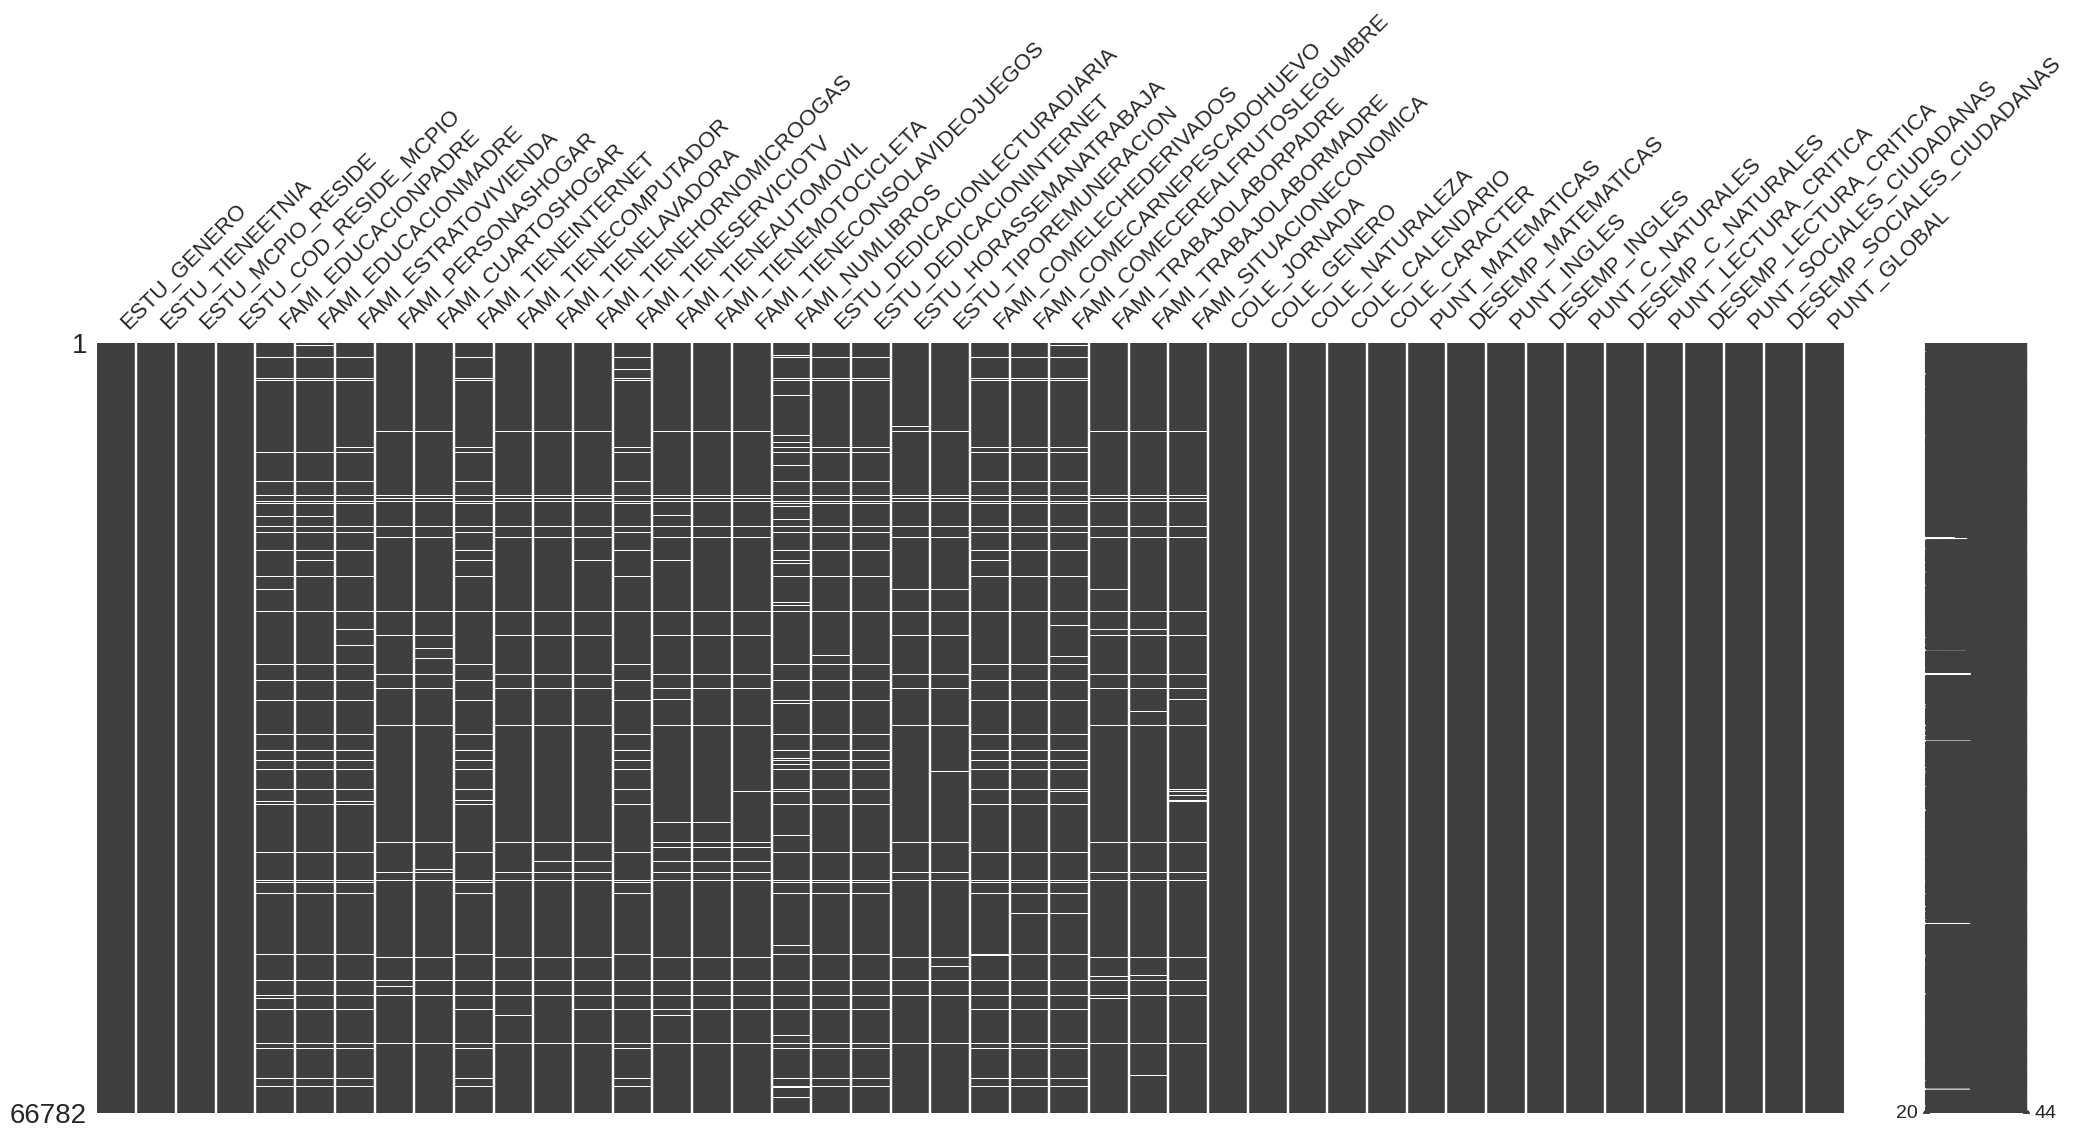

In [89]:
# Matriz de identificación de columnas con datos perdidos

msno.matrix(UndAnalisisFinal)

In [100]:
# Cuantificación por variable de los datos perdidos

DatPerdUnAnFinal = pd.DataFrame(UndAnalisisFinal.isna().sum(), columns=['n'])
DatPerdUnAnFinal = DatPerdUnAnFinal[DatPerdUnAnFinal['n'] > 0]
DatPerdUnAnFinal = DatPerdUnAnFinal.sort_values('n', ascending = False)
# DatPerdUnAnFinal = DatPerdUnAnFinal.plot(kind='barh')

DatPerdUnAnFinal

,n
FAMI_NUMLIBROS,5241
FAMI_COMELECHEDERIVADOS,4303
FAMI_ESTRATOVIVIENDA,4032
FAMI_COMECEREALFRUTOSLEGUMBRE,3907
ESTU_DEDICACIONINTERNET,3855
FAMI_TIENESERVICIOTV,3807
FAMI_COMECARNEPESCADOHUEVO,3798
ESTU_DEDICACIONLECTURADIARIA,3764
FAMI_TIENEINTERNET,3713
FAMI_EDUCACIONPADRE,3655


MCA

In [101]:
# Cuantificación de los datos perdidos en función del territorio

dfDatosPerdidos = UndAnalisisFinal[
				UndAnalisisFinal['ESTU_TIENEETNIA'].isna() |
        UndAnalisisFinal['FAMI_NUMLIBROS'].isna() |
				UndAnalisisFinal['FAMI_COMELECHEDERIVADOS'].isna() |
				UndAnalisisFinal['FAMI_ESTRATOVIVIENDA'].isna() |
				UndAnalisisFinal['FAMI_COMECEREALFRUTOSLEGUMBRE'].isna() |
				UndAnalisisFinal['ESTU_DEDICACIONINTERNET'].isna() |
				UndAnalisisFinal['FAMI_TIENESERVICIOTV'].isna() |
				UndAnalisisFinal['FAMI_COMECARNEPESCADOHUEVO'].isna() |
				UndAnalisisFinal['ESTU_DEDICACIONLECTURADIARIA'].isna() |
				UndAnalisisFinal['FAMI_TIENEINTERNET'].isna() |
				UndAnalisisFinal['FAMI_EDUCACIONPADRE'].isna() |
				UndAnalisisFinal['FAMI_EDUCACIONMADRE'].isna() |
				UndAnalisisFinal['FAMI_SITUACIONECONOMICA'].isna() |
				UndAnalisisFinal['ESTU_TIPOREMUNERACION'].isna() |
				UndAnalisisFinal['FAMI_TIENEAUTOMOVIL'].isna() |
				UndAnalisisFinal['FAMI_TIENECONSOLAVIDEOJUEGOS'].isna() |
				UndAnalisisFinal['FAMI_TRABAJOLABORPADRE'].isna() |
				UndAnalisisFinal['FAMI_TIENEHORNOMICROOGAS'].isna() |
				UndAnalisisFinal['ESTU_HORASSEMANATRABAJA'].isna() |
				UndAnalisisFinal['FAMI_TIENEMOTOCICLETA'].isna() |
				UndAnalisisFinal['FAMI_TRABAJOLABORMADRE'].isna() |
				UndAnalisisFinal['FAMI_CUARTOSHOGAR'].isna() |
				UndAnalisisFinal['FAMI_TIENELAVADORA'].isna() |
				UndAnalisisFinal['FAMI_TIENECOMPUTADOR'].isna() |
				UndAnalisisFinal['FAMI_PERSONASHOGAR'].isna()
]

print(dfDatosPerdidos.shape) # (9815, 40)

dfDatPer = dfDatosPerdidos.groupby('ESTU_MCPIO_RESIDE')['ESTU_MCPIO_RESIDE'].agg(['size']).reset_index()
dfDatPer.columns = ['ESTU_MCPIO_RESIDE', 'DatPerd']
dfDatPer = round((dfDatPer.sort_values('DatPerd', ascending=False)),3)
dfDatPer
# dfDatosPerdidos.head(10)

(9852, 44)


,ESTU_MCPIO_RESIDE,DatPerd
21,MEDELLÍN,3372
7,CALI,2356
27,SANTA MARTA,789
13,CÚCUTA,773
17,IBAGUÉ,760
5,BUCARAMANGA,659
25,PITALITO,215
20,MALAMBO,158
11,COROZAL,119
22,MOSQUERA,83


Análisis del impacto de la pérdida de datos

In [102]:
dfSinDatosPerdidos = UndAnalisisFinal[
   ~ (
				UndAnalisisFinal['ESTU_TIENEETNIA'].isna() |
				UndAnalisisFinal['FAMI_NUMLIBROS'].isna() |
				UndAnalisisFinal['FAMI_COMELECHEDERIVADOS'].isna() |
				UndAnalisisFinal['FAMI_ESTRATOVIVIENDA'].isna() |
				UndAnalisisFinal['FAMI_COMECEREALFRUTOSLEGUMBRE'].isna() |
				UndAnalisisFinal['ESTU_DEDICACIONINTERNET'].isna() |
				UndAnalisisFinal['FAMI_TIENESERVICIOTV'].isna() |
				UndAnalisisFinal['FAMI_COMECARNEPESCADOHUEVO'].isna() |
				UndAnalisisFinal['ESTU_DEDICACIONLECTURADIARIA'].isna() |
				UndAnalisisFinal['FAMI_TIENEINTERNET'].isna() |
				UndAnalisisFinal['FAMI_EDUCACIONPADRE'].isna() |
				UndAnalisisFinal['FAMI_EDUCACIONMADRE'].isna() |
				UndAnalisisFinal['FAMI_SITUACIONECONOMICA'].isna() |
				UndAnalisisFinal['ESTU_TIPOREMUNERACION'].isna() |
				UndAnalisisFinal['FAMI_TIENEAUTOMOVIL'].isna() |
				UndAnalisisFinal['FAMI_TIENECONSOLAVIDEOJUEGOS'].isna() |
				UndAnalisisFinal['FAMI_TRABAJOLABORPADRE'].isna() |
				UndAnalisisFinal['FAMI_TIENEHORNOMICROOGAS'].isna() |
				UndAnalisisFinal['ESTU_HORASSEMANATRABAJA'].isna() |
				UndAnalisisFinal['FAMI_TIENEMOTOCICLETA'].isna() |
				UndAnalisisFinal['FAMI_TRABAJOLABORMADRE'].isna() |
				UndAnalisisFinal['FAMI_CUARTOSHOGAR'].isna() |
				UndAnalisisFinal['FAMI_TIENELAVADORA'].isna() |
				UndAnalisisFinal['FAMI_TIENECOMPUTADOR'].isna() |
				UndAnalisisFinal['FAMI_PERSONASHOGAR'].isna()
   )
]

dfSinDatosPerdidos.shape



# dfDatosPerdidos2.head(10)

(56930, 44)

In [103]:
dfDatPer2y = dfSinDatosPerdidos.groupby('ESTU_MCPIO_RESIDE')['ESTU_MCPIO_RESIDE', 'PUNT_GLOBAL'].agg(['size', 'mean', 'std']).reset_index()
dfDatPer2y.columns = ['ESTU_MCPIO_RESIDE', 'fi_sin_dp', 'X_puntaje_sin_dp', 'DE_sin_dp']
dfDatPer2y = round((dfDatPer2y.sort_values('fi_sin_dp', ascending=False)),3)
# print(dfDatPer2y)

In [104]:
dfDatPer2x = UndAnalisisFinal.groupby('ESTU_MCPIO_RESIDE')[['ESTU_MCPIO_RESIDE', 'PUNT_GLOBAL']].agg(['size', 'mean', 'std']).reset_index()
dfDatPer2x.columns = ['ESTU_MCPIO_RESIDE', 'fi_con_dp', 'X_puntaje_con_dp', 'DE_con_dp']
dfDatPer2x = round((dfDatPer2x.sort_values('fi_con_dp', ascending=False)),3)
# print(dfDatPer2x)

In [105]:
ImpacDatPerd = pd.merge(dfDatPer2x, dfDatPer2y, on='ESTU_MCPIO_RESIDE', how='left')
ImpacDatPerd['fi_diferencia'] = ImpacDatPerd['fi_sin_dp']-ImpacDatPerd['fi_con_dp']
ImpacDatPerd['DismPorcentual'] = ImpacDatPerd['fi_diferencia']/ ImpacDatPerd['fi_con_dp']*100
ImpacDatPerd['Fi_sin_dp'] = ImpacDatPerd['fi_sin_dp'].cumsum() # Cálculo de la frecuencia acumulada
ImpacDatPerd['Fi(%)'] = ((ImpacDatPerd['fi_sin_dp'] / ImpacDatPerd['fi_sin_dp'].sum()) * 100).round(3).cumsum()
ImpacDatPerd = ImpacDatPerd[['ESTU_MCPIO_RESIDE','fi_con_dp', 'fi_sin_dp', 'fi_diferencia', 'DismPorcentual', 'Fi_sin_dp', 'Fi(%)', 'X_puntaje_con_dp', 'X_puntaje_sin_dp', 'DE_con_dp', 'DE_sin_dp']]
ImpacDatPerd = round(ImpacDatPerd, 3)
ImpacDatPerd

,ESTU_MCPIO_RESIDE,fi_con_dp,fi_sin_dp,fi_diferencia,DismPorcentual,Fi_sin_dp,Fi(%),X_puntaje_con_dp,X_puntaje_sin_dp,DE_con_dp,DE_sin_dp
0,MEDELLÍN,22404,19032,-3372,-15.051,19032,33.431,252.454,255.750,51.930,51.445
1,CALI,13688,11332,-2356,-17.212,30364,53.336,251.023,253.743,47.960,47.422
2,CÚCUTA,6527,5754,-773,-11.843,36118,63.443,271.463,272.982,51.546,51.398
3,IBAGUÉ,6069,5309,-760,-12.523,41427,72.768,260.756,263.019,50.440,50.111
4,BUCARAMANGA,5017,4358,-659,-13.135,45785,80.423,279.818,281.997,53.275,53.032
5,SANTA MARTA,4734,3945,-789,-16.667,49730,87.353,246.268,249.617,49.613,49.353
6,PITALITO,1384,1169,-215,-15.535,50899,89.406,274.761,277.185,51.939,51.488
7,MOSQUERA,935,852,-83,-8.877,51751,90.903,273.972,274.941,45.674,45.451
8,COROZAL,890,771,-119,-13.371,52522,92.257,258.749,260.215,50.611,50.518
9,MALAMBO,840,682,-158,-18.810,53204,93.455,246.095,249.282,51.507,51.886


<AxesSubplot: >

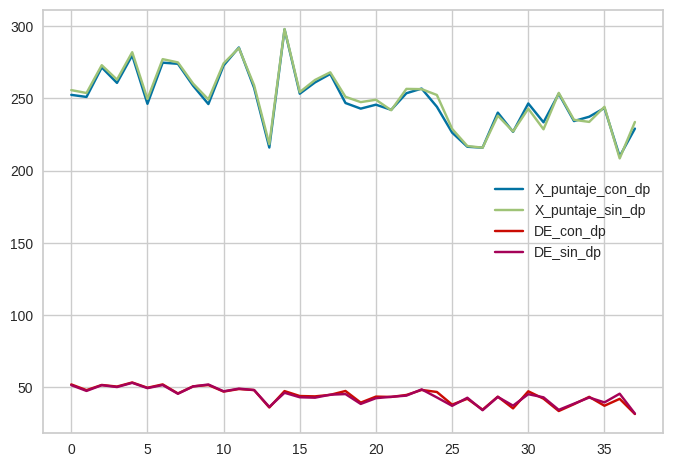

In [110]:
# Análisis gráfico del impacto de la eliminación de los datos perdidos en la distribución de los datos

ImpacDatPerd[['X_puntaje_con_dp', 'X_puntaje_sin_dp', 'DE_con_dp', 'DE_sin_dp']].plot()

<AxesSubplot: >

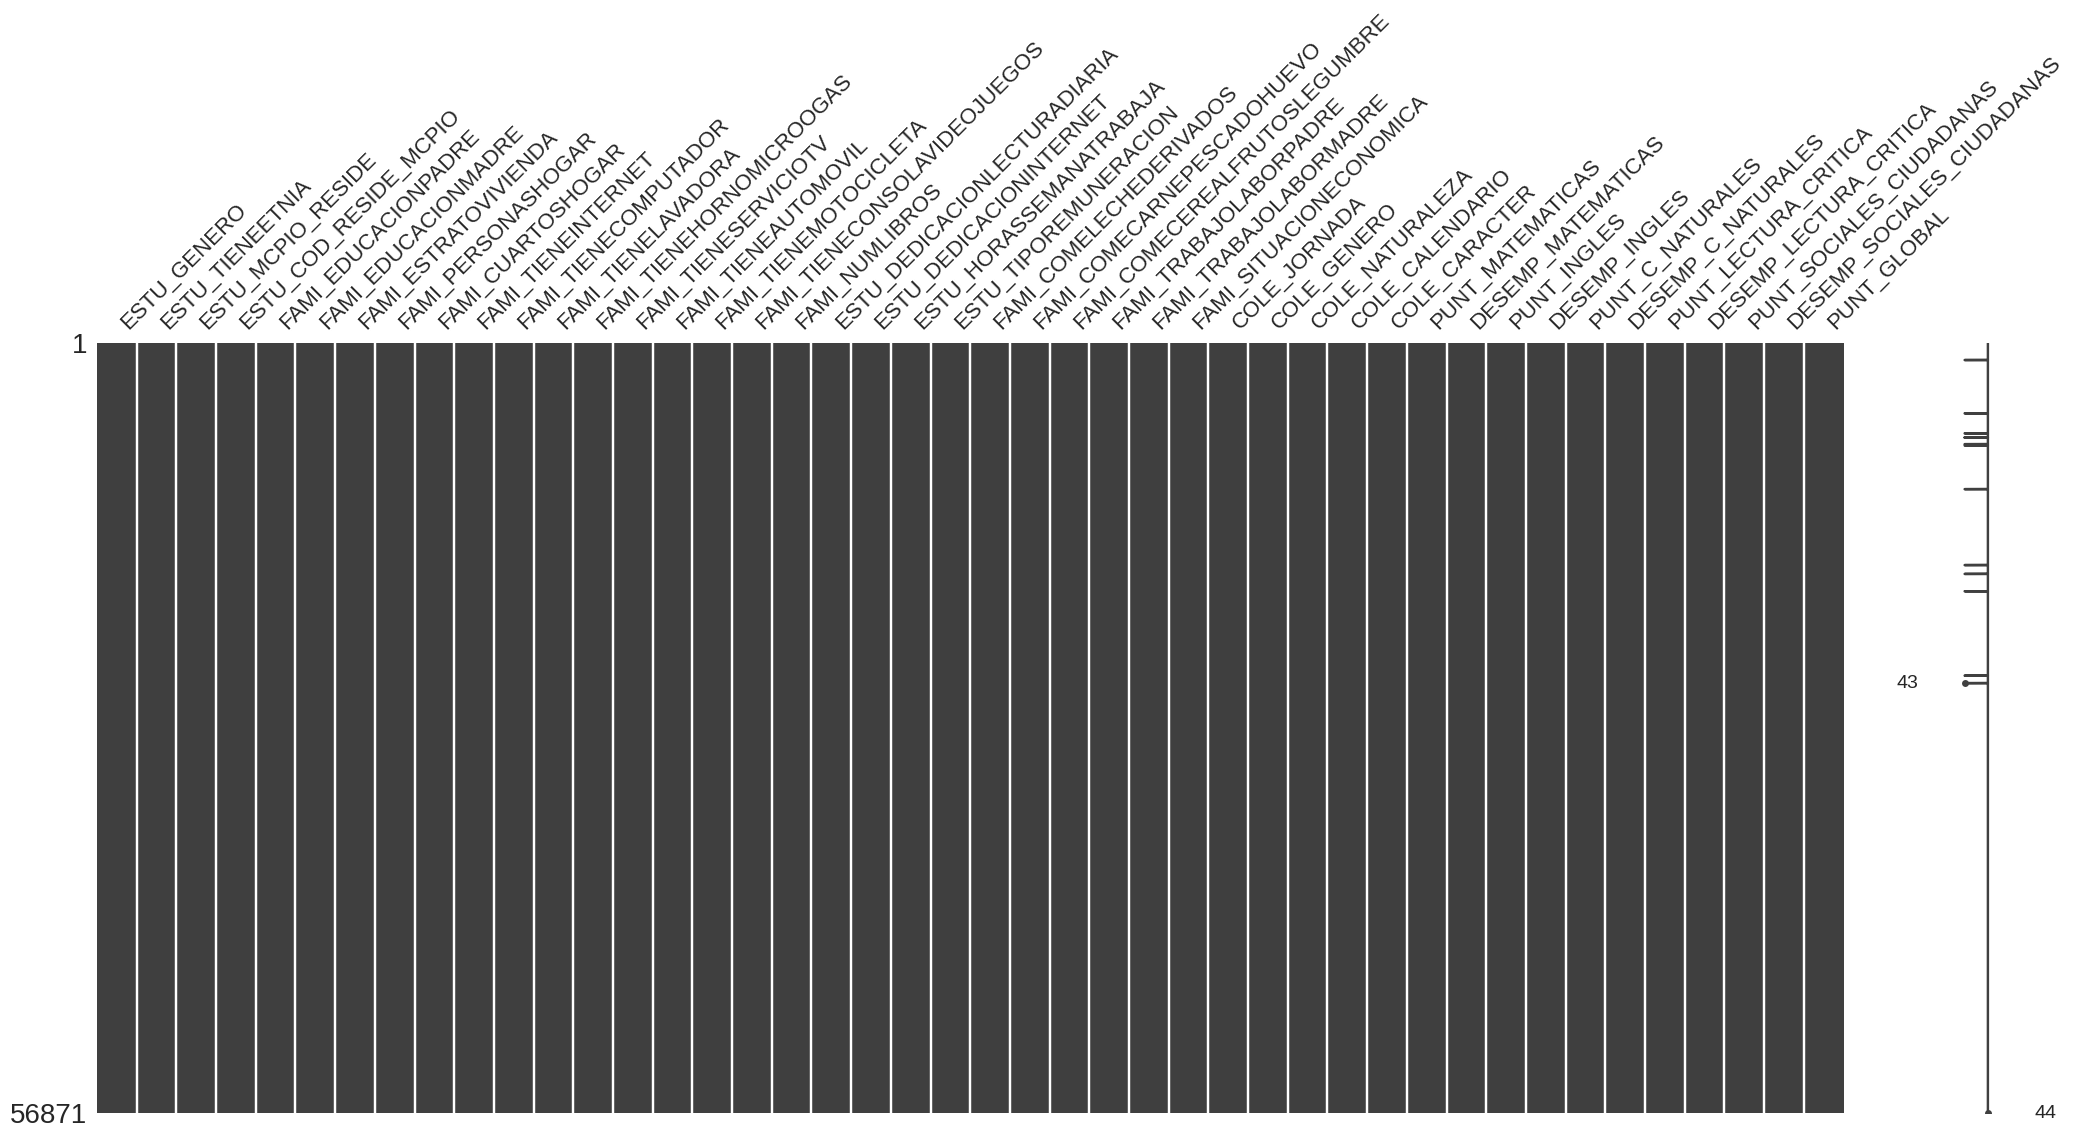

In [111]:
msno.matrix(dfSinDatosPerdidos)

In [112]:
# Vector para descartar los municipios con menos de 30 sujetos

FiltroMun2 = [
    'CHÁMEZA',
    'TUNUNGUÁ',
    'TUTAZÁ'
]

dfSinDatosPerdidos = dfSinDatosPerdidos[~dfSinDatosPerdidos['ESTU_MCPIO_RESIDE'].isin(FiltroMun2)]

dfSinDatosPerdidos.shape

(56871, 44)

                                             |          | [  0%]   00:00 -> (? left)


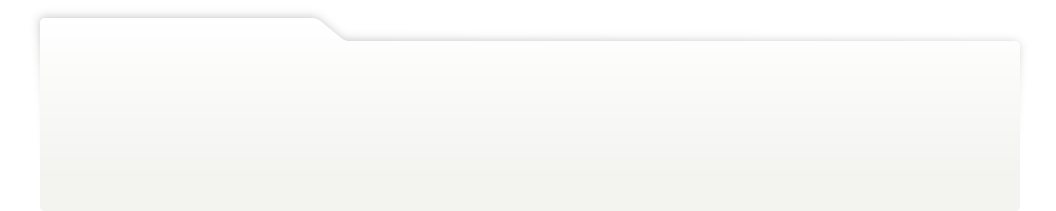
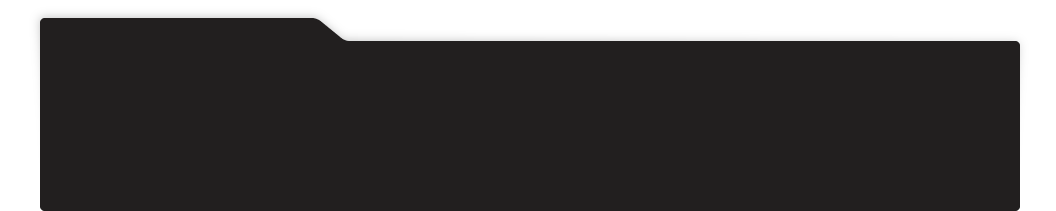
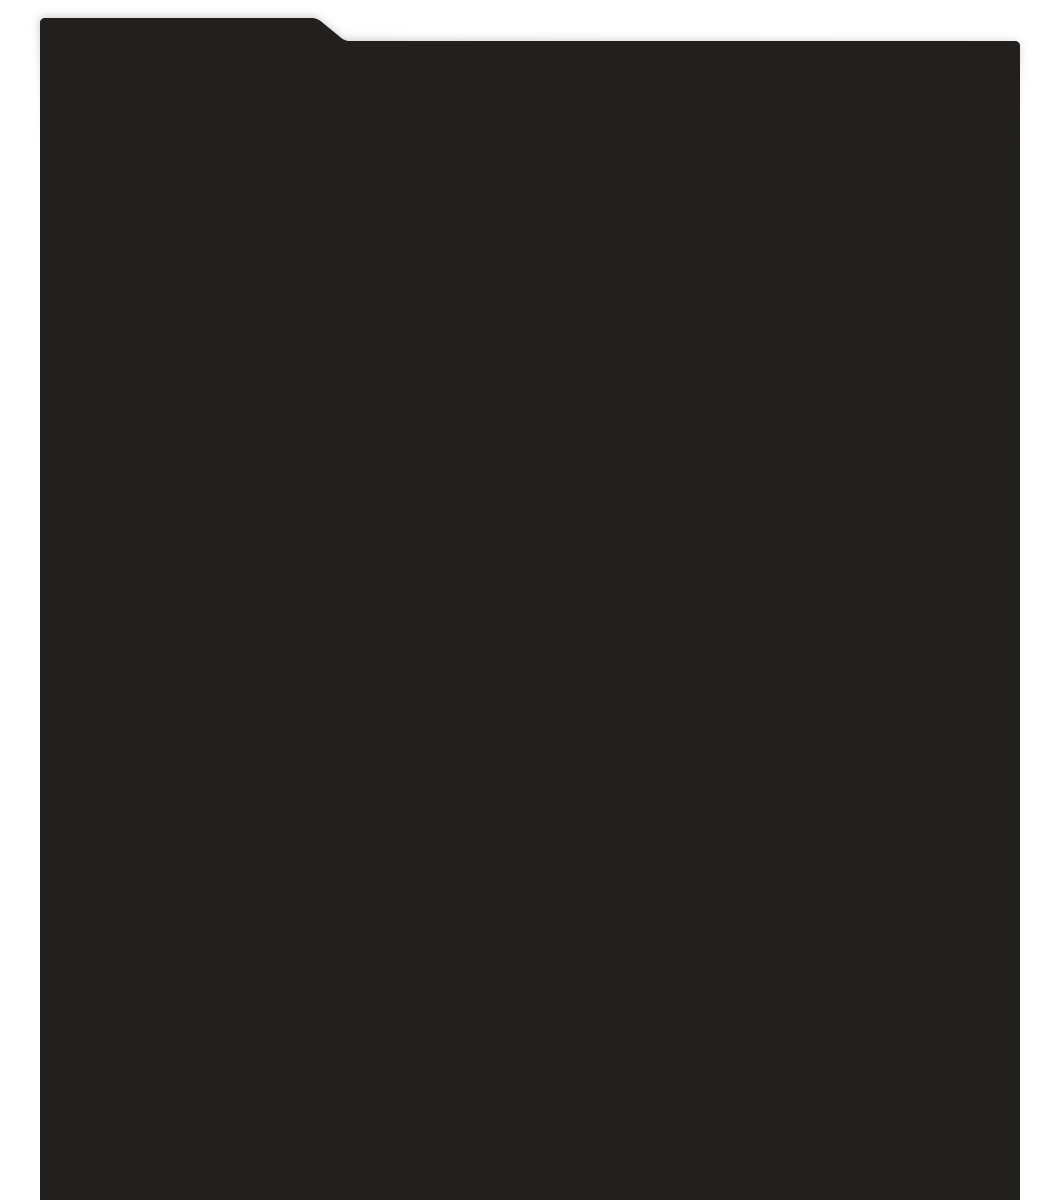
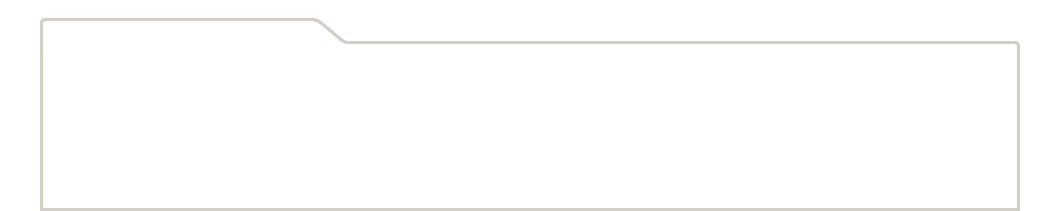
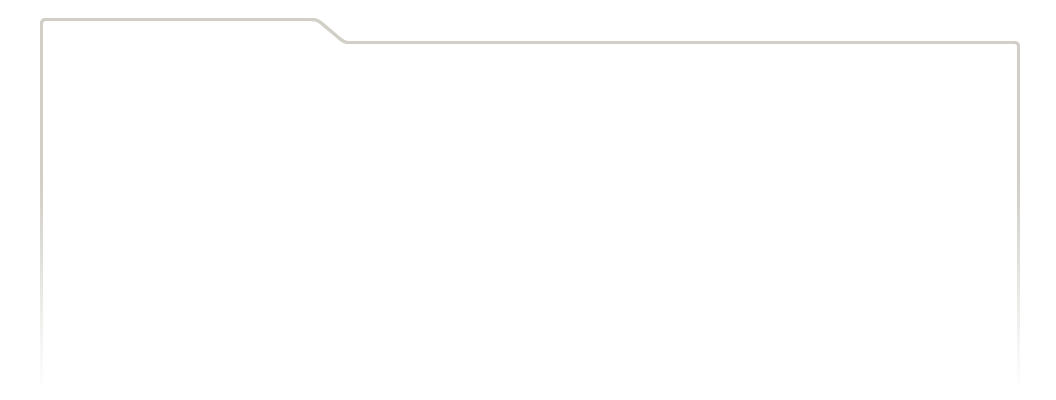
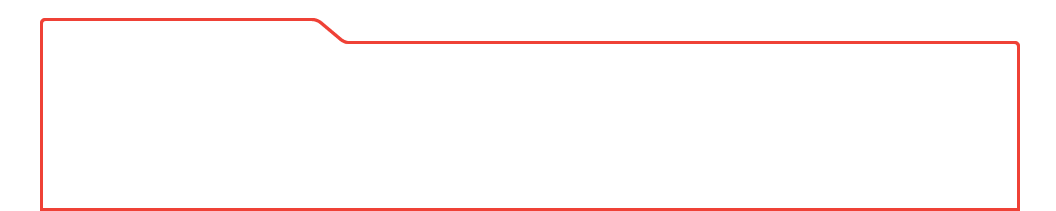
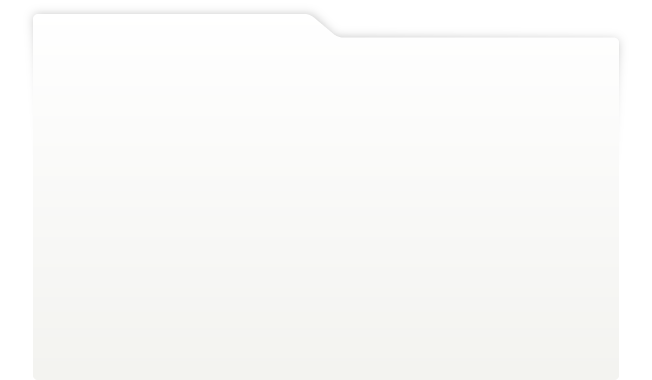
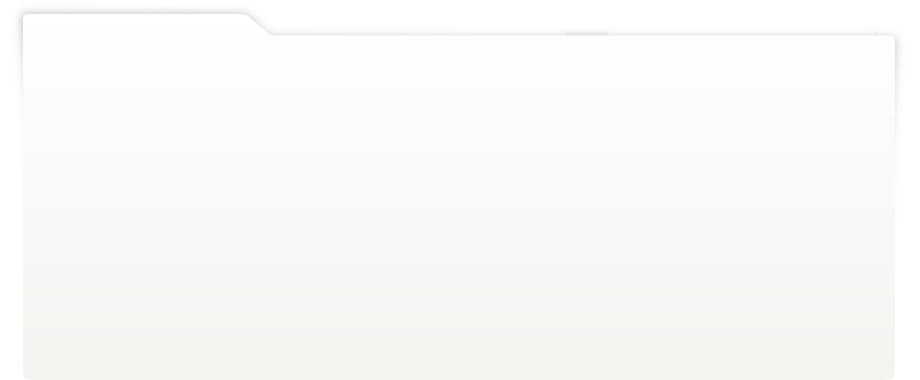
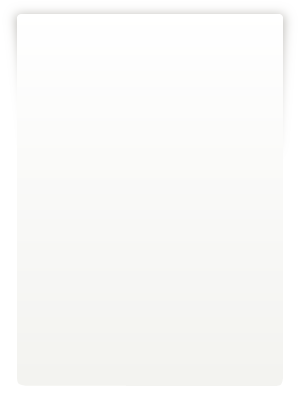
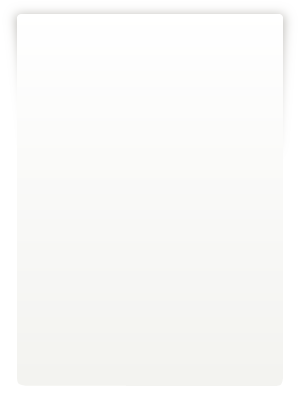
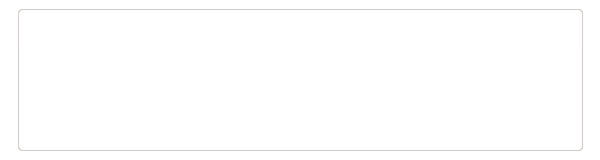
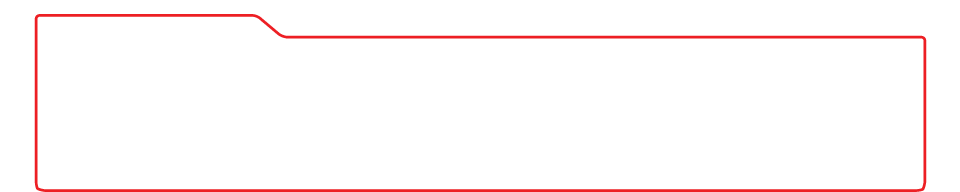
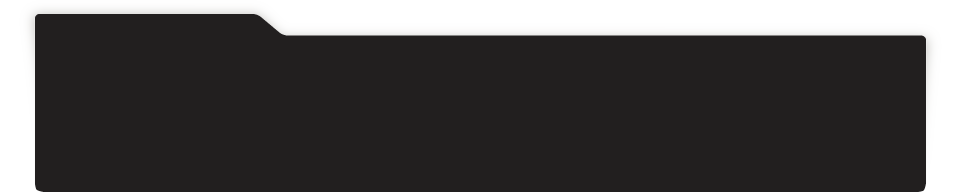
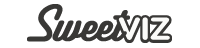
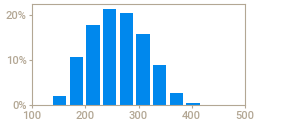
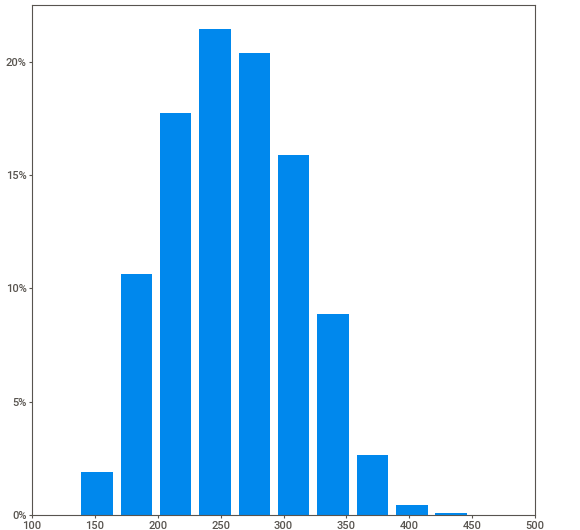
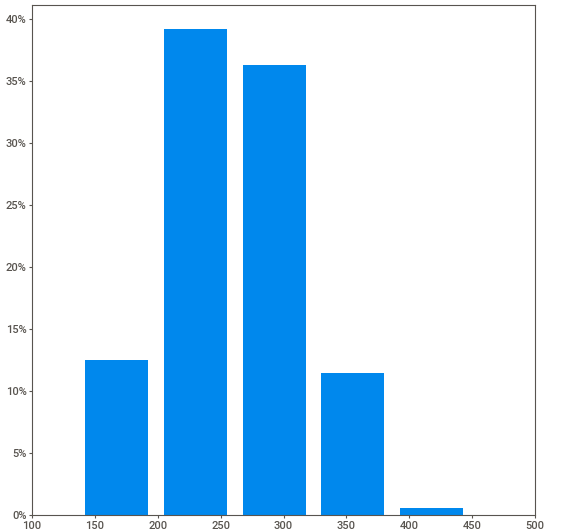
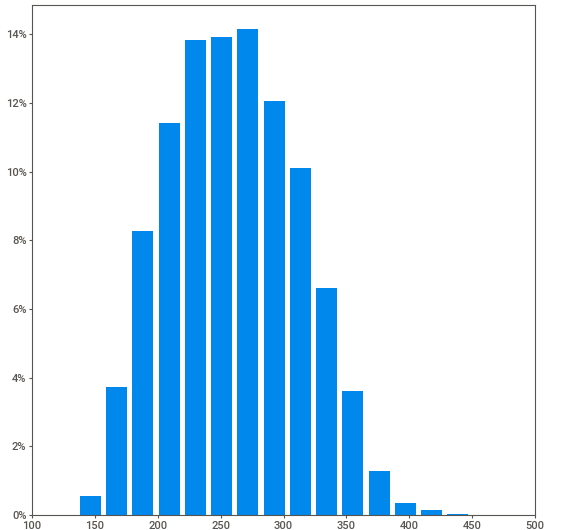
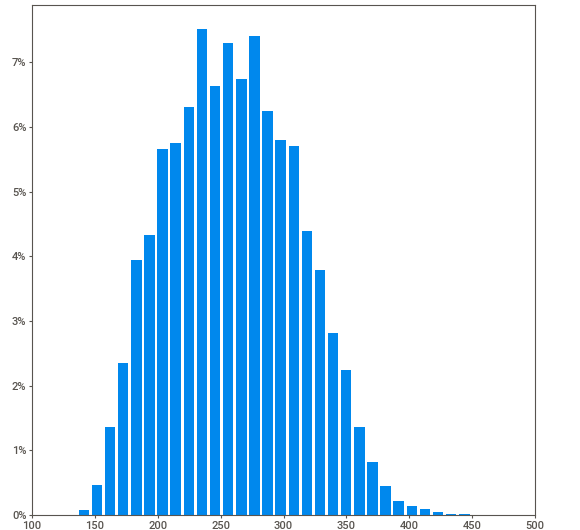
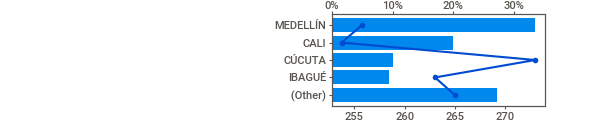
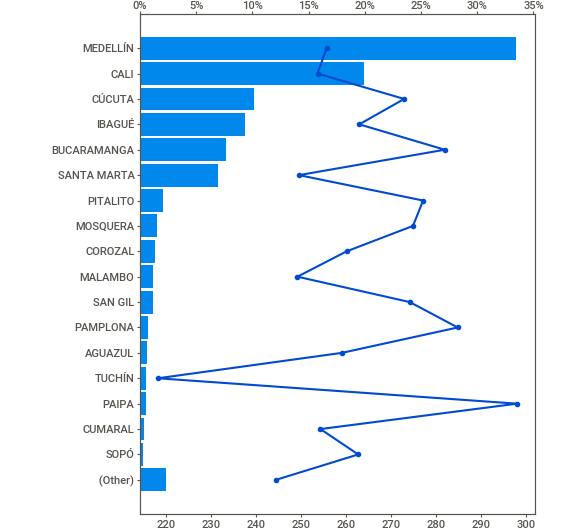
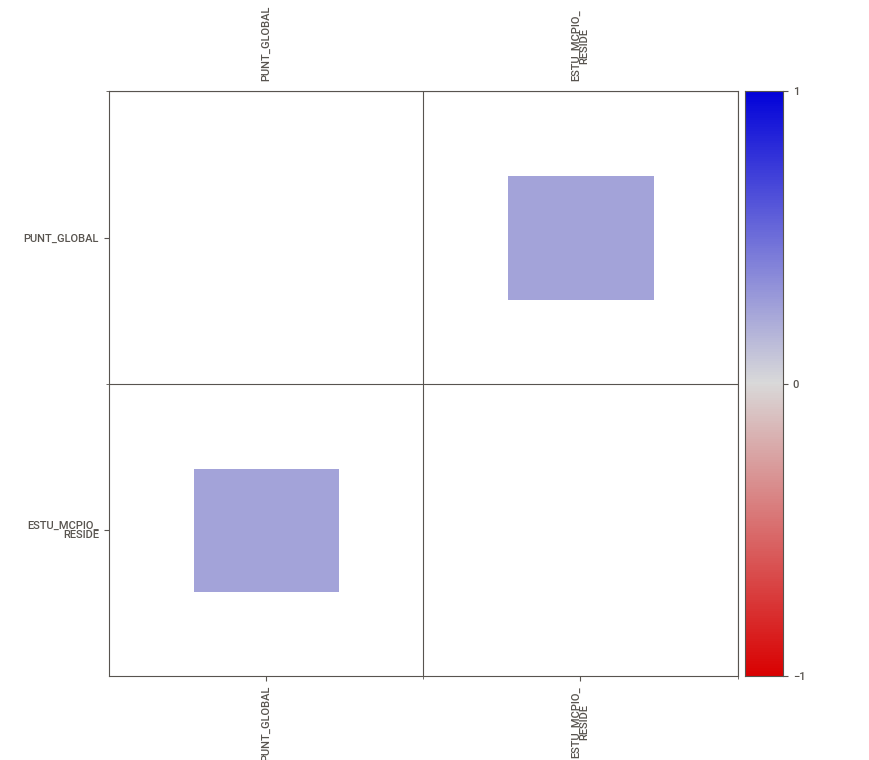
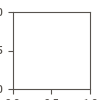

In [113]:
# Análisis descriptivo y de correlaciónes. Target_feat='PUNT_GLOBAL'

AnalisisPrelim = dfSinDatosPerdidos[['PUNT_GLOBAL', 'ESTU_MCPIO_RESIDE']]

AnalisisPrelim = sv.analyze(AnalisisPrelim, target_feat='PUNT_GLOBAL', pairwise_analysis='on') # 'on' si quiere hacer análisis de correlación
AnalisisPrelim.show_notebook()

Los datos tienden levemente hacia los mayores puntajes (sesgo=0.176) con una forma platicúrtica en la distribución (k=-0,548). El análisis de correlación sugirio que existe asociación entre las variables.

*********************************

In [ ]:
# Crear un gráfico de caja
# BoxPlotPuntaje = sns.boxplot(x=dfSinDatosPerdidos['PUNT_GLOBAL'])

EDA Saber 11

Análisis del desempeño

In [114]:
# Crear columnas para las tablas cruzadas

dfAnalisisAreas = dfSinDatosPerdidos

dfAnalisisAreas['Matematicas'] = "Matemáticas"
dfAnalisisAreas['LecCritica'] = "Lectura crítica"
dfAnalisisAreas['Sociales'] = "Sociales y ciudadanas"
dfAnalisisAreas['CienciasNaturales'] = "Ciencias naturales"
dfAnalisisAreas['Ingles'] = "Ingles"

# dfAnalisisAreas.head()

In [115]:
# Tabla de frecuencias por nivel de desempeño - Matemáticas

DistMat = dfAnalisisAreas.rename(columns={'DESEMP_MATEMATICAS': 'Prueba'})
DistMat = pd.crosstab(DistMat.Matematicas, DistMat.Prueba, normalize = "index")
DistMat = DistMat.rename_axis(None)
# DistMat

In [116]:
# Tabla de frecuencias por nivel de desempeño - Lectura crítica

DistLec = dfAnalisisAreas.rename(columns={'DESEMP_LECTURA_CRITICA': 'Prueba'})
DistLec = pd.crosstab(DistLec.LecCritica, DistLec.Prueba, normalize = "index")
DistLec = DistLec.rename_axis(None)
# DistLec

In [117]:
# Tabla de frecuencias por nivel de desempeño - Sociales y ciudadanas

DistSociales = dfAnalisisAreas.rename(columns={'DESEMP_SOCIALES_CIUDADANAS': 'Prueba'})
DistSociales = pd.crosstab(DistSociales.Sociales, DistSociales.Prueba, normalize = "index")
DistSociales = DistSociales.rename_axis(None)
# DistSociales

In [118]:
# Tabla de frecuencias por nivel de desempeño - Ciencias naturales

DistNaturales = dfAnalisisAreas.rename(columns={'DESEMP_C_NATURALES': 'Prueba'})
DistNaturales = pd.crosstab(DistNaturales.CienciasNaturales, DistNaturales.Prueba, normalize = "index")
DistNaturales = DistNaturales.rename_axis(None)
# DistNaturales

In [119]:
# Concatenar tablas de frecuencias por nivel de desempeño

tbAnalisisAreas = pd.concat([DistMat, DistLec, DistSociales, DistNaturales], ignore_index=False, axis=0)

for col in ['1', '2', '3', '4']:
    tbAnalisisAreas[col] *= 100

tbAnalisisAreas = round(tbAnalisisAreas, 3)

tbAnalisisAreas

Prueba,1,2,3,4
Matemáticas,8.560,33.687,51.685,6.068
Lectura crítica,3.394,29.711,50.414,16.481
Sociales y ciudadanas,24.928,41.269,30.230,3.573
Ciencias naturales,18.461,48.519,29.713,3.307


In [120]:
# Tabla de frecuencias por nivel de desempeño - Ingles

DistIngles = dfAnalisisAreas.rename(columns={'DESEMP_INGLES': 'Prueba'})
DistIngles = pd.crosstab(DistIngles.Ingles, DistIngles.Prueba, normalize = "index")
DistIngles = DistIngles.rename_axis(None)
column_orden = ['A-', 'A1', 'A2', 'B1', 'B+']
DistIngles = DistIngles[column_orden]

for col in ['A-', 'A1', 'A2', 'B1', 'B+']:
    DistIngles[col] *= 100

tbAnalisisIngles = round(DistIngles, 3)
tbAnalisisIngles

Prueba,A-,A1,A2,B1,B+
Ingles,38.953,28.252,18.839,10.791,3.165


## Integración bases de datos

In [121]:
# Creación de llave para el inner join

dfSinDatosPerdidos = dfSinDatosPerdidos.rename(columns={'ESTU_COD_RESIDE_MCPIO': 'CodMunicipio'})
# UndAnalisisFinal.columns

In [122]:
# Inner Join UndAnalis - Índice CTI
df_consolidado = pd.merge(dfSinDatosPerdidos, df_cti, on='CodMunicipio', how='inner')

df_consolidado.shape # 56908, 120

(56871, 124)

## EDA datos consolidados

In [140]:
# Tabla de contingencia
# Territorio, índice de madurez y media del puntaje global

tabla_ = df_consolidado.groupby(['Territorio'])[['IndiceMadurezCTI', 'PUNT_GLOBAL']].agg('mean', 'mean')
tabla_ = tabla_.round(3)
tabla_ = tabla_.sort_values(by='IndiceMadurezCTI', ascending=False).reset_index()
tabla_

,Territorio,IndiceMadurezCTI,PUNT_GLOBAL
0,Medellín,4.00,255.750
1,Ibagué,3.77,263.019
2,Bucaramanga,3.70,281.997
3,Sopó,3.70,262.775
4,Cali,3.40,253.743
5,Cúcuta,3.29,272.982
6,Paipa,3.26,298.054
7,Mosquera,3.18,274.941
8,Guatapé,3.17,256.420
9,Pamplona,3.10,284.869


Pendiente: 19.63421112806492
Intercepto: 195.9038163131068
R2: 0.2351034392516509


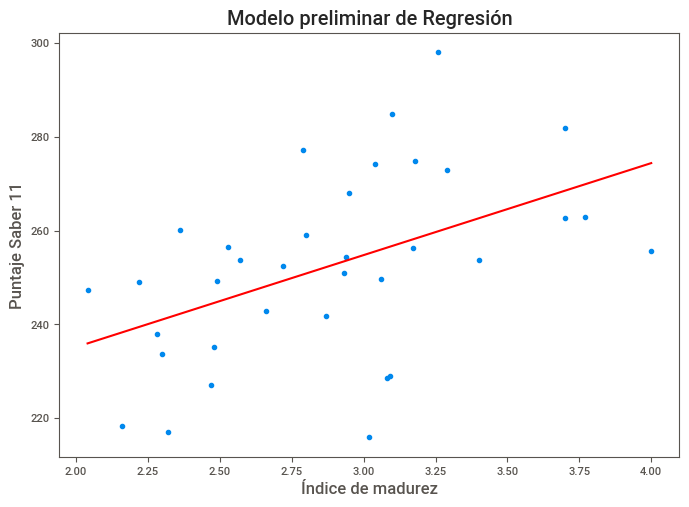

In [141]:
# Modelo de regresión 1. IndiceMadurezCTI ~  Media del PUNT_GLOBAL

x = np.array(tabla_['IndiceMadurezCTI']).reshape(-1, 1)
y = np.array(tabla_['PUNT_GLOBAL'])

# Ajustar una regresión lineal
regresion = LinearRegression()
regresion.fit(x, y)

# Obtener los coeficientes de la regresión
pendiente = regresion.coef_[0]
intercepto = regresion.intercept_

# Calcular el coeficiente de determinación (R2)
r2 = regresion.score(x, y)

# Imprimir los resultados
print(f"Pendiente: {pendiente}")
print(f"Intercepto: {intercepto}")
print(f"R2: {r2}")

# Crear el gráfico de dispersión con la línea de regresión
plt.scatter(tabla_['IndiceMadurezCTI'], tabla_['PUNT_GLOBAL'])
plt.plot(tabla_['IndiceMadurezCTI'], pendiente * tabla_['IndiceMadurezCTI'] + intercepto, color='red')
plt.title("Modelo preliminar de Regresión")
plt.xlabel("Índice de madurez")
plt.ylabel("Puntaje Saber 11")
plt.legend()
plt.show()


In [ ]:
# #Listar las columnas

# nombres_columnas2 = df_consolidado.columns
# nombres_columnas_lista2 = nombres_columnas2.to_list()

# for columna in nombres_columnas_lista2:
#    print(columna)

In [125]:
VectorModReg = [
				#'ESTU_GENERO', # Genero dejar
				#'ESTU_MCPIO_RESIDE',
				#'CodMunicipio',
				'FAMI_EDUCACIONPADRE',
				'FAMI_EDUCACIONMADRE',
				'FAMI_ESTRATOVIVIENDA',
				'FAMI_PERSONASHOGAR',
				'FAMI_CUARTOSHOGAR',
				'FAMI_TIENEINTERNET',
				'FAMI_TIENECOMPUTADOR',
				'FAMI_TIENELAVADORA',
				'FAMI_TIENEHORNOMICROOGAS',
				'FAMI_TIENESERVICIOTV',
				'FAMI_TIENEAUTOMOVIL',
				'FAMI_TIENEMOTOCICLETA',
				'FAMI_TIENECONSOLAVIDEOJUEGOS',
				'FAMI_NUMLIBROS',
				'ESTU_DEDICACIONLECTURADIARIA',
				'ESTU_DEDICACIONINTERNET',
				'ESTU_HORASSEMANATRABAJA',
				'ESTU_TIPOREMUNERACION',
				'FAMI_COMELECHEDERIVADOS',
				'FAMI_COMECARNEPESCADOHUEVO',
				'FAMI_COMECEREALFRUTOSLEGUMBRE',
				'FAMI_TRABAJOLABORPADRE',
				'FAMI_TRABAJOLABORMADRE',
				'FAMI_SITUACIONECONOMICA',
				'COLE_NATURALEZA',
				#'ESTU_PRIVADO_LIBERTAD',
				#'PUNT_MATEMATICAS',
				#'DESEMP_MATEMATICAS',
				#'PUNT_INGLES',
				#'DESEMP_INGLES',
				# 'PUNT_C_NATURALES',
				#'DESEMP_C_NATURALES',
				# 'PUNT_LECTURA_CRITICA',
				#'DESEMP_LECTURA_CRITICA',
				# 'PUNT_SOCIALES_CIUDADANAS',
				#'DESEMP_SOCIALES_CIUDADANAS',
				'PUNT_GLOBAL',
				# 'Matematicas',
				# 'LecCritica',
				# 'Sociales',
				# 'CienciasNaturales',
				# 'Ingles',
				# 'Ranking',
				'Territorio',
				# 'IndiceMadurezCTI',
				# 'IndiceCapacidades',
				# 'IndiceResultados',
				# 'IndicePercepcion',
				# 'Personas_PerDim',
				# 'Calidad de Vida_PerDim',
				# 'Gobernanza_PerDim',
				# 'Hábitat_PerDim',
				# 'Medio ambiente_PerDim',
				# 'Desarrollo económico_PerDim',
				'Educación_PerSubdim',
				'Cohesión social y sociedad incluyente_PerSubdim',
				'Equidad_PerSubdim',
				'Cultura ciudadana_PerSubdim',
				'Seguridad ciudadana_PerSubdim',
				'Salud y Bienestar_PerSubdim',
				'Ocio_PerSubdim',
				'Gobierno abierto y participación ciudadana_PerSubdim',
				'Gobierno multinivel_PerSubdim',
				'Colaboración entre ciudades y territorios_PerSubdim',
				'Gobierno digital_PerSubdim',
				'Movilidad Inteligente_PerSubdim',
				'Gestión del espacio público_PerSubdim',
				'Infraestructura inteligente_PerSubdim',
				'Servicios públicos_PerSubdim',
				'Gestión de residuos_PerSubdim',
				'Gestión de recursos_PerSubdim',
				'Calidad ambiental_PerSubdim',
				'Cambio climático_PerSubdim',
				'Gestión del Riesgo_PerSubdim',
				'Emprendimiento e innovación_PerSubdim',
				'Empleo_PerSubdim',
				'Economía del conocimiento_PerSubdim',
				'Entorno competitivo y productivo_PerSubdim',
				'Economía circular_PerSubdim',
				'Transformación digital_PerSubdim',
				# 'Personas_ResDim',
				# 'Calidad de Vida_ResDim',
				# 'Hábitat_ResDim',
				# 'Gobernanza_ResDim',
				# 'Medio Ambiente_ResDim',
				# 'Desarrollo Económico_ResDim',
				'Educación_ResSubdim',
				'Equidad_ResSubdim',
				'Sociedad Incluyente y Cohesión Social_ResSubdim',
				'Cultura Ciudadana_ResSubdim',
				'Ocio y turismo_ResSubdim',
				'Salud y Bienestar_ResSubdim',
				'Seguridad Ciudadana_ResSubdim',
				'Movilidad Inteligente_ResSubdim',
				'Infraestructura inteligente_ResSubdim',
				'Gestión del espacio público_ResSubdim',
				'Servicios públicos_ResSubdim',
				'Gobierno Abierto y participación ciudadana_ResSubdim',
				'Colaboración entre ciudades y territorios_ResSubdim',
				'Gobernanza multinivel_ResSubdim',
				'Gobierno Digital_ResSubdim',
				'Gestión de recursos_ResSubdim',
				'Calidad ambiental_ResSubdim',
				'Gestión del riesgo_ResSubdim',
				'Gestión de residuos_ResSubdim',
				'Cambio climático_ResSubdim',
				'Emprendimiento e innovación_ResSubdim',
				'Economía del conocimiento_ResSubdim',
				'Entorno productivo y competitivo_ResSubdim',
				'Empleo_ResSubdim',
				'Transformación digital_ResSubdim',
				'Economía circular_ResSubdim',
				'Institucionalidad e innovación_Cap',
				'Liderazgo y Capital Humano_Cap',
				'Analítica y gestión de datos_Cap',
				'Infraestructura digital e interoperabilidad_Cap',
				'Tecnología y estándares_Cap'


				]

In [ ]:
# Exportar la base de datos

#Nombre del archivo de salida
# nombre_archivo = "df_consolidadoSaber11.xlsx"

# df_consolidado.to_excel(nombre_archivo, index=False)

In [127]:
# Data set final modelo de regresión

DfModRegresion_ = df_consolidado[VectorModReg]
# dfSinDatosPerdidos = dfSinDatosPerdidos[~dfSinDatosPerdidos['ESTU_MCPIO_RESIDE'].isin(FiltroMun2)]
DfModRegresion_.shape

(56871, 84)

In [149]:
formula = 'PUNT_GLOBAL ~ Territorio'

model = sm.formula.ols(formula, data= tabla_).fit()
model.summary()

FloatingPointError: ignored

In [ ]:
from pycaret.regression import models

In [ ]:
RegModel = setup(data=DfModRegresion_, target='PUNT_GLOBAL', session_id=123)

,Description,Value
0,Session id,123
1,Target,PUNT_GLOBAL
2,Target type,Regression
3,Original data shape,"(56908, 84)"
4,Transformed data shape,"(56908, 174)"
5,Transformed train set shape,"(39835, 174)"
6,Transformed test set shape,"(17073, 174)"
7,Ordinal features,9
8,Numeric features,57
9,Categorical features,26


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
best = compare_models(include=['catboost', 'lightgbm', 'ridge' ], sort='R2')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:40:01
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# plot residuals
plot_model(best, plot = 'residuals')

In [ ]:
# plot error
plot_model(best, plot = 'error')

In [ ]:
# plot feature importance
plot_model(best, plot = 'feature')

In [ ]:
evaluate_model(best)